# Repdopa_proc_reproduce_matlab_Part2

This part will focus on Extract values from beta maps and caclulate the correlation between Resting state and CS offsets.

The rationale is simple:
1. Eextract beta value of ROIs from the beta map of the CS+ offset and CS- offset;
2. Extract beta values of ROIs from the beta map of each TR in four resting phase;
2. Calculate the correlation between all TRs of resting with both CS+ offset and CS- offset.
3. Threshold the correlation 
4. Count the number of supra-threshold TRs
5. Correlate the number of supra-threold TRs with SCR response

I will first write a function and then use Nipype's Node muplti-process. In this function, I did the following steps:

1. load the beta map from CS+ offset and CS- offset (two beta images)
2. load the beta maps from the first resting phase (475 images)
3. cantenate the all beta images from the experiment with the 475 images from each resting phase, results in a four 4-D beta image;
4. Using ROI mask as the index to extract the beta value from this 4-D beta images, thus get a 4-D beta ROI images;
5. Calculate the correlation matrix using each 4-D beta roi images;
6. Extract the two columns of the correlation matrix corresponding to CS+ and CS- offsets, get two correlation columns, one for CS+ offset, one for CS- offset;
7. Fisher-Z transform for these two columns
8. Calculate the mean and sd of Fisher-Z transformed data for CS+ and CS- offset separately. This mean and SD for CS+ and CS- will serve as the baseline for threshoulding the reactivation latter;
9. Repeat the step 3 to 7, get the transformed correlation columns for CS+ and CS- for each restings.
10. Use the baseline means and sd to normalize the correlation columns for each restings.
11. count the number of cells that great than 2 for CS+ CS-offset in four resting session.

In [1]:
## which python is using
## when using the Nipype_tutorial docker image, it should be "/opt/miniconda-latest/envs/neuro/bin/python"
import sys
sys.executable

'/opt/miniconda-latest/envs/neuro/bin/python'

In [16]:
import os
from os.path import join
import glob # use glob to get the file names

#subject_list = ['001','002'] # using two subject's data to test the procedure.
subject_list = ['001','002', '003', '004', '005',
                '011','012', '013', '014', '015', '016'] # using two subject's data to test the procedure.

# ses_list = ['d1', 'd2', 'd3']
ses_list = ['d2']  # focus on day2
#task_list_all = ['exp', 'rest-1', 'rest-2', 'rest-3', 'rest-4']  # preprocessing 
#task_list_exp =['exp']  # for 1st level of CS+ offset
#rest_list = ['rest-2', 'rest-3', 'rest-4'] # for 1st level of CS+ offset
task_list_all = ['exp', 'rest_run-1', 'rest_run-2', 'rest_run-3', 'rest_run-4']  # preprocessing 
task_list_exp =['exp']  # for 1st level of CS+ offset
task_list_rest = ['rest_run-1', 'rest_run-2', 'rest_run-3', 'rest_run-4'] # for 1st level of CS+ offset

mask_dir = '/home/hcp4715/Data/RepDopa/Nipy/ROI_masks'
mask_list = glob.glob(join(mask_dir,'*.nii')) 

# extract the ROI names
roi_names = [os.path.splitext(os.path.basename(x))[0] for x in glob.glob(join(mask_dir,'*.nii'))]
roi_names = [roi_names[x] for x in (1,3,8)] # select right and left amygdala, vmpfc

base_dir = '/home/hcp4715/Data/RepDopa/Nipy/reprod_spm'
#input_dir = join(base_dir, 'datasink', 'rsa_1stLevel',)

In [4]:
roi_names

['rAMY50', 'lAMY50', 'vmPFC50']

In [24]:
# test the get_react_baseline function
subject_id = '001'
roi_id = 'rAMY50'
tmp1, tmp2 = get_react_baseline(base_dir, mask_dir, roi_id, subject_id)
tmp1

CSpl_offset_5_z  CSmin_offset_5_z
count       472.000000        472.000000
mean         -0.002805          0.003978
std           0.147354          0.172234

In [18]:
# define a function get the baseline (rest1) for the later reactivation counts
def get_react_baseline(input_dir, mask_dir, roi_id, subject_id):  
    import os
    from os.path import join
    import glob # use glob to get the file names

    import numpy as np    # for manipulating arrays
    import pandas as pd   # dataframe manipulation

    import nibabel as nib # load img data
    from nilearn.image import concat_imgs # used to combine 3d images to 4D
    
    # load the mask image
    mask_id = join(mask_dir,roi_id+'.nii')
    mask = nib.load(mask_id)
    mask_data = mask.get_data()
    index = (mask_data !=0)      # get the index of ROI

    exp_data_dir = join(input_dir, 'datasink', 'rsa_1stLevel', 'sub-' + subject_id, 'ses-d2', 'task-exp')
    rest_data_dir = join(input_dir, 'datasink', 'rsa_1stLevel', 'sub-' + subject_id, 'ses-d2', 'task-rest_run-1')
    
    exp_data_dir = join(input_dir, 'datasink', 'rsa_1stLevel', 'sub-'+subject_id, 'ses-d2', 'task-exp/')
    rest1_data_dir = join(input_dir, 'datasink', 'rsa_1stLevel', 'sub-'+subject_id, 'ses-d2', 'task-rest_run-1')
    
    file_names_exp = glob.glob(join(exp_data_dir,'beta*'))      # all filenames with
    file_names_rest1 = glob.glob(join(rest1_data_dir,'beta*'))  # all filenames with
    
    file_names_cor1 = file_names_cor2 = file_names_cor3 = file_names_cor4 = file_names_exp 
    file_names_cor1 +=file_names_rest1
    
    beta_cor1_4d = concat_imgs(file_names_cor1)          # concatenate the images as a 4-d image
    beta_roi_cor1 = beta_cor1_4d.get_data()[index, :]    # extract beta value from the ROI
    
    column_names_cor1 = ['CSpl', 'CSmin', 'CSpl_offset_5', 'CSpl_offset_10', 'CSmin_offset_5', 
                       'CSmin_offset_10', 'rating', 'context', 'intercept_exp']
    rest1_names = ['rest_run-1_beta'+ str(x) for x in np.arange(1,476)]
    rest1_names += ['intercept_rest_run-1']
    column_names_cor1 += rest1_names
    
    df_cor1 = pd.DataFrame(data=beta_roi_cor1[0:,0:],                   # values
                           index=range(beta_roi_cor1.shape[0]),         # 1st column as index
                           columns=range(beta_roi_cor1.shape[1]))     
    df_cor1.columns = column_names_cor1  # rename columns 
    del beta_cor1_4d # delete the large file to release memory

    df_cor1_mat = df_cor1.corr() # get the corr matrix
    # extract the corr coeffecient related to cs+ and cs- only
    df_cor1_mat = df_cor1_mat.loc['rest_run-1_beta1':'rest_run-1_beta473',['CSpl_offset_5', 'CSmin_offset_5']]
    df_cor1_mat['Resting'] = 'rest_run-1'
    df_cor1_mat[['CSpl_offset_5_z', 'CSmin_offset_5_z']] = np.arctanh(df_cor1_mat[['CSpl_offset_5', 'CSmin_offset_5']])

    df_cor1_mat_stat = df_cor1_mat[['CSpl_offset_5_z', 'CSmin_offset_5_z']].describe()
    df_cor1_mat_stat = df_cor1_mat_stat.iloc[[0,1,2],]
    
    df_cor1_mat['CSpl_offset_5_zz'] = (df_cor1_mat['CSpl_offset_5'] - df_cor1_mat_stat['CSpl_offset_5_z'].loc['mean'])/df_cor1_mat_stat['CSpl_offset_5_z'].loc['std']
    df_cor1_mat['CSmin_offset_5_zz'] = (df_cor1_mat['CSmin_offset_5'] - df_cor1_mat_stat['CSmin_offset_5_z'].loc['mean'])/df_cor1_mat_stat['CSmin_offset_5_z'].loc['std']
 
    # threshold
    df_cor1_mat['CSpl_reacti_num'] = np.where((df_cor1_mat['CSpl_offset_5_zz'] > 2 ), 1, 0)
    df_cor1_mat['CSmin_reacti_num'] = np.where((df_cor1_mat['CSmin_offset_5_zz'] > 2 ), 1, 0)

    # sum of the supra-threshold TRs
    df_react_num_r1 = df_cor1_mat[['Resting','CSpl_reacti_num', 'CSmin_reacti_num']].groupby(['Resting']).sum()
    df_react_num_r1.reset_index(level=0, inplace=True)
    df_react_num_r1.columns = df_react_num_r1.columns.map(''.join).str.strip('')
     
    df_react_num_r1['ROI'] = roi_id
    df_react_num_r1['Subject'] = subject_id
    
    # write the baselilne to csv file
    file_name_bl = 'baseline_sub-' + subject_id + '_ses-d2_' + 'sub-' + subject_id + '_mask_' + roi_id +'.csv'
    file_name_bl = join(input_dir, 'datasink','rsa_react', 'sub-'+subject_id,file_name_bl)
    df_cor1_mat_stat.to_csv(file_name_bl)
    
    file_name_r1_num = 'react_num_rest_run-1_sub-' + subject_id + '_ses-d2_' + 'sub-' + subject_id + '_mask_' + roi_id +'.csv'
    file_name_r1_num = join(input_dir, 'datasink','rsa_react', 'sub-'+subject_id,file_name_r1_num)
    
    df_react_num_r1.to_csv(file_name_r1_num)

    return df_cor1_mat_stat, df_react_num_r1

In [25]:
# define a function to get the reactivated number for one resting run and one ROI.
def calc_reactiv(input_dir, subject_id, rest_id, mask_dir, roi_id, df_cor1_mat_stat):  
    import os
    from os.path import join
    import glob # use glob to get the file names

    import numpy as np    # for manipulating arrays
    import pandas as pd   # dataframe manipulation

    import nibabel as nib # load img data
    from nilearn.image import concat_imgs # used to combine 3d images to 4D
    
    mask_id = join(mask_dir,roi_id+'.nii')
    mask = nib.load(mask_id)
    mask_data = mask.get_data()
    index = (mask_data !=0)      # get the index of ROI
    
    exp_data_dir = join(input_dir, 'datasink', 'rsa_1stLevel', 'sub-' + subject_id, 'ses-d2', 'task-exp')
    rest_data_dir = join(input_dir, 'datasink', 'rsa_1stLevel', 'sub-' + subject_id, 'ses-d2', 'task-'+rest_id)
    
    file_names_exp = glob.glob(join(exp_data_dir,'beta*'))      # all filenames with
    file_names_rest = glob.glob(join(rest_data_dir,'beta*'))  # all filenames with

    file_names_cor = file_names_exp 
    file_names_cor +=file_names_rest

    beta_cor_4d = concat_imgs(file_names_cor)
    beta_roi_cor = beta_cor_4d.get_data()[index, :]

    column_names_cor = ['CSpl', 'CSmin', 'CSpl_offset_5', 'CSpl_offset_10', 'CSmin_offset_5', 
                       'CSmin_offset_10', 'rating', 'context', 'intercept_exp']
    rest_names = [rest_id+'beta'+ str(x) for x in np.arange(1,476)]
    rest_names += ['intercept_rest1']
    column_names_cor += rest_names

    df_cor = pd.DataFrame(data=beta_roi_cor[0:,0:],                   # values
                           index=range(beta_roi_cor.shape[0]),         # 1st column as index
                           columns=range(beta_roi_cor.shape[1])) 
    df_cor.columns = column_names_cor
    del beta_cor_4d

    df_cor_mat = df_cor.corr()
    df_cor_mat = df_cor_mat.loc[rest_id+'beta1':rest_id+'beta473',['CSpl_offset_5', 'CSmin_offset_5']]
    df_cor_mat['Resting'] = rest_id

    # Fisher z-transform.
    df_cor_mat[['CSpl_offset_5_z', 'CSmin_offset_5_z']] = np.arctanh(df_cor_mat[['CSpl_offset_5', 'CSmin_offset_5']])
    #df_cor[['CSpl_offset_5_z', 'CSmin_offset_5_z']] = np.arctanh(df_cor[['CSpl_offset_5', 'CSmin_offset_5']])

    # standadize using the first resting's mean and SD
    df_cor_mat['CSpl_offset_5_zz'] = (df_cor_mat['CSpl_offset_5'] - df_cor1_mat_stat['CSpl_offset_5_z'].loc['mean'])/df_cor1_mat_stat['CSpl_offset_5_z'].loc['std']
    df_cor_mat['CSmin_offset_5_zz'] = (df_cor_mat['CSmin_offset_5'] - df_cor1_mat_stat['CSmin_offset_5_z'].loc['mean'])/df_cor1_mat_stat['CSmin_offset_5_z'].loc['std']
    
    # threshold
    df_cor_mat['CSpl_reacti_num'] = np.where((df_cor_mat['CSpl_offset_5_zz'] > 2 ), 1, 0)
    df_cor_mat['CSmin_reacti_num'] = np.where((df_cor_mat['CSmin_offset_5_zz'] > 2 ), 1, 0)

    # sum of the supra-threshold TRs
    df_react_num = df_cor_mat[['Resting','CSpl_reacti_num', 'CSmin_reacti_num']].groupby(['Resting']).sum()

    df_react_num.reset_index(level=0, inplace=True)
    df_react_num.columns = df_react_num.columns.map(''.join).str.strip('')
    df_react_num['ROI'] = roi_id
    df_react_num['Subject'] = subject_id
    
    # write the baselilne to csv file    
    file_name_num = 'react_num_' + rest_id + '_sub-' + subject_id + '_ses-d2_' + 'sub-' + subject_id + '_mask_' + roi_id +'.csv'
    file_name_num = join(input_dir, 'datasink','rsa_react', 'sub-'+subject_id,file_name_num)
    
    df_react_num.to_csv(file_name_num)

    return df_react_num


In [6]:
# this will combine the data from four rest run and combine them for each ROI (not for all rois)
def comb_write(input_dir, subject_id, roi_id, df_react_num_r1, df_react_num):
    import pandas as pd
    from os.path import join
    
    df_react_num.insert(0, df_react_num_r1)
    df = pd.concat(df_react_num)
    
    file_name_num = 'react_num_all_sub-'+ subject_id+'_ses-d2_'+ '_mask_' + roi_id +'.csv'
    file_name_num = join(input_dir, 'datasink','rsa_react', 'sub-'+subject_id, file_name_num)
    
    df.to_csv(file_name_num)

In [7]:
from nipype import Node, MapNode, Workflow              # Get the Node and Workflow object
from nipype.algorithms.misc import Gunzip
from nipype import SelectFiles                 # Import the SelectFiles to read data iterately.
from nipype.interfaces.fsl import ExtractROI   # import node for removing the first 5 TRs for all sessions
from nipype.interfaces.io import DataSink      # clearer output
from nipype.interfaces.utility import Function, IdentityInterface

In [8]:
#get_react_baseline(input_dir, mask_dir, roi_id, subject_id)
#calc_reactiv(input_dir, subject_id, rest_id, mask_dir, roi_id, df_cor1_mat_stat)
infosource = Node(IdentityInterface(fields=['subject_id',
                                            'roi_id',
                                            'input_dir'],
                                    input_dir = base_dir),
                  name='infosource')

infosource.iterables = [('subject_id', subject_list),
                        ('roi_id', roi_names),]

get_baseline = Node(Function(input_names=['input_dir', 'mask_dir', 'roi_id', 'subject_id'],
                             output_names=['df_cor1_mat_stat', 'df_react_num_r1'],
                             function=get_react_baseline),
                    name='get_baseline')
get_baseline.inputs.input_dir = base_dir
get_baseline.inputs.mask_dir = mask_dir

# MapNode, get the .
get_React_Num = MapNode(Function(input_names = ['input_dir', 'mask_dir', 
                                                'roi_id', 'subject_id',
                                                'df_cor1_mat_stat',
                                                'rest_id'],
                                 output_names=['df_react_num'], 
                                 function=calc_reactiv),
                        iterfield = ['rest_id'],
                        name='get_React_Num')
get_React_Num.inputs.input_dir = base_dir
get_React_Num.inputs.mask_dir = mask_dir
get_React_Num.inputs.rest_id = ['rest-2', 'rest-3', 'rest-4']

#df_react_num_r1, df_react_num, subject_id, input_dir)
comb_write_node = Node(Function(input_names=['input_dir', 'subject_id', 'roi_id',
                                             'df_react_num_r1', 
                                             'df_react_num'],
                             output_names=['df_react_num'],
                             function=comb_write),
                    name='comb_write_node')
comb_write_node.inputs.input_dir = base_dir

rsa_react = Workflow(name='rsa_react',
                           base_dir=join(base_dir, 'derivatives/'))

rsa_react.connect([(infosource, get_baseline, [('subject_id', 'subject_id'), 
                                               ('roi_id', 'roi_id')]),
                   
                   (infosource, get_React_Num, [('subject_id', 'subject_id'), 
                                                ('roi_id', 'roi_id')]),
                   (get_baseline, get_React_Num, [('df_cor1_mat_stat', 'df_cor1_mat_stat')]),
                   
                   (infosource, comb_write_node, [('subject_id', 'subject_id'),
                                                  ('roi_id', 'roi_id')]),
                   (get_baseline, comb_write_node, [('df_react_num_r1', 'df_react_num_r1')]),
                   (get_React_Num, comb_write_node, [('df_react_num', 'df_react_num')]),
                  ])

200424-22:31:10,522 nipype.workflow INFO:
	 Generated workflow graph: /home/hcp4715/Data/RepDopa/BIDS/reprod_spm/derivatives/rsa_react/graph.png (graph2use=colored, simple_form=True).


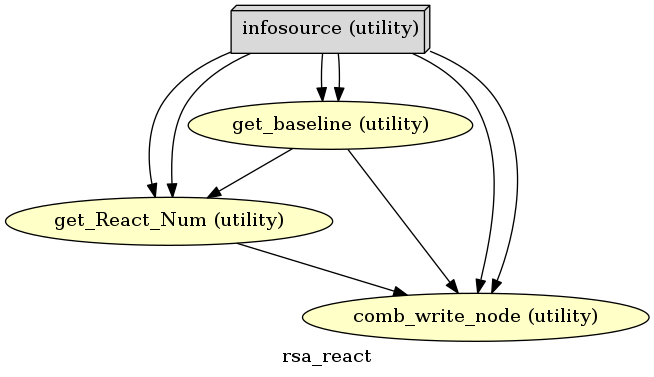

In [9]:
rsa_react.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=join(rsa_react.base_dir, 'rsa_react', 'graph.png'))

200424-22:31:10,755 nipype.workflow INFO:
	 Generated workflow graph: /home/hcp4715/Data/RepDopa/BIDS/reprod_spm/derivatives/rsa_react/graph.png (graph2use=flat, simple_form=True).


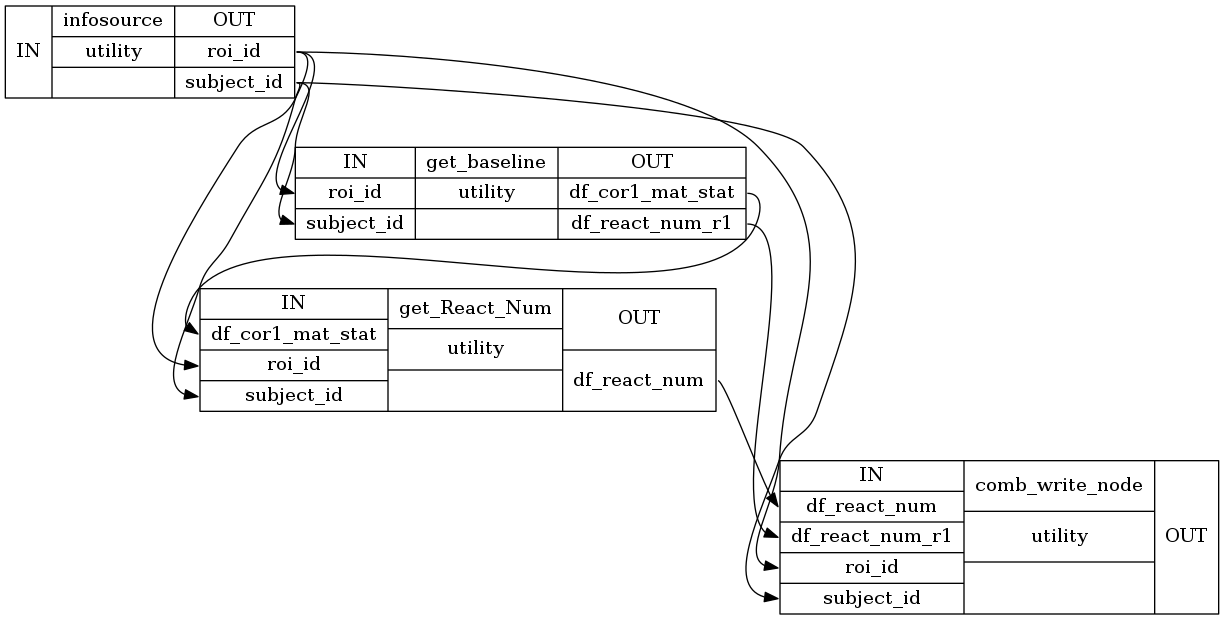

In [10]:
rsa_react.write_graph(graph2use='flat', format='png', simple_form=True)

from IPython.display import Image
Image(filename=join(rsa_react.base_dir, 'rsa_react', 'graph_detailed.png'))

In [11]:
rsa_react.run('MultiProc', plugin_args={'n_procs': 8})

200424-22:31:10,799 nipype.workflow INFO:
	 Workflow rsa_react settings: ['check', 'execution', 'logging', 'monitoring']
200424-22:31:10,814 nipype.workflow INFO:
	 Running in parallel.
200424-22:31:10,818 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 6 jobs ready. Free memory (GB): 27.95/27.95, Free processors: 8/8.
200424-22:31:10,871 nipype.workflow INFO:
	 [Job 0] Cached (rsa_react.get_baseline).
200424-22:31:10,873 nipype.workflow INFO:
	 [Job 3] Cached (rsa_react.get_baseline).
200424-22:31:10,874 nipype.workflow INFO:
	 [Job 6] Cached (rsa_react.get_baseline).
200424-22:31:10,875 nipype.workflow INFO:
	 [Job 9] Cached (rsa_react.get_baseline).
200424-22:31:10,877 nipype.workflow INFO:
	 [Job 12] Cached (rsa_react.get_baseline).
200424-22:31:10,879 nipype.workflow INFO:
	 [Job 15] Cached (rsa_react.get_baseline).
200424-22:31:14,819 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 18 jobs ready. Free memory (GB): 27.95/27.95, Free processors: 8/8.
200424-22:31:

In [12]:
#!nipypecli crash crash*